In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
from scipy.integrate import cumtrapz

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

import scipy

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size
ng = 256 # no. of recurrent units

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

array([0.001     , 0.00146494, 0.00214533, 0.00314341, 0.00460845,
       0.00676165, 0.00993093, 0.01460734, 0.02153287, 0.03184467,
       0.04732185, 0.07082877, 0.10715791, 0.16468228, 0.25815343,
       0.40688312, 0.59311688, 0.74184657, 0.83531772, 0.89284209,
       0.92917123, 0.95267815, 0.96815533, 0.97846713, 0.98539266,
       0.99006907, 0.99323835, 0.99539155, 0.99685659, 0.99785467,
       0.99853506, 0.999     ])

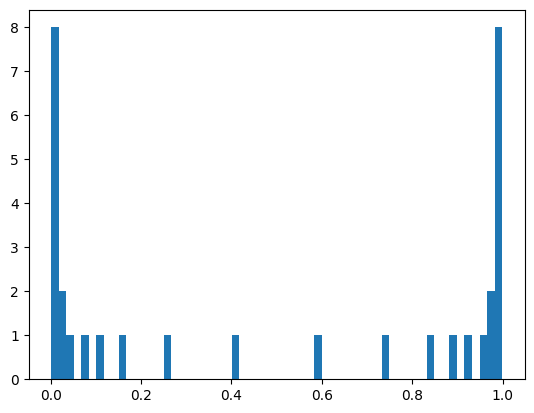

In [9]:
# Get even distribution from distribution function

def inverse_transform_sampling(prob_density_func, num_samples):
    # Create an array across the interval [0, 1]
    x = np.linspace(0.001, 0.999, 10000)

    # Calculate the cumulative distribution function (CDF)
    cdf = cumtrapz(prob_density_func(x), x)
    cdf = np.insert(cdf, 0, 0)

    # Use the CDF to get the inverse CDF
    inverse_cdf = np.interp(np.linspace(0, cdf[-1], num_samples), cdf, x)

    return inverse_cdf

# alphas = inverse_transform_sampling(lambda x: 1/(x*(1-x)), 100)
alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 32)
plt.hist(alphas, bins = 60)
alphas

In [ ]:
# FF Grid search

alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 32)

# alphas = np.linspace(0.85, 0.94, 100)
# alphas = 1-np.geomspace(0.001,1,30)
grid_scores = []
for alpha in tqdm(alphas):
    print(f'Alpha: {alpha}')
    # model = FFGC(alpha = alpha)
    model = RNNGC(ng = ng, alpha = alpha, norm = "l2")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    # Train model
    for i in range(train_steps-len(model.total_loss_history)):
        r = torch.rand((bs, 2), device = device)*4*np.pi - 2*np.pi
        loss = model.train_step(inputs = r, labels = r, optimizer = optimizer)

    # Plot loss history
    # fig,axs = plt.subplots(1,3,figsize=(9,3))
    # axs[0].semilogy(np.array(model.total_loss_history)-model.loss_minima(), label = 'Total loss', color = 'black')
    # axs[1].semilogy(np.array(model.capacity_loss_history)-model.loss_minima(), label = 'Capacity loss', color = 'red')
    # axs[2].semilogy(model.similarity_loss_history, label = 'Similarity loss', color = 'blue')
    # fig.tight_layout()
    # fig.legend()
    # plt.savefig(f'./gridsearch/ffgc_loss_alpha_{alpha}.png')
    # plt.close()

    # evaluate on 64x64 grid
    res = 64
    x = np.linspace(-1, 1, res)*2*np.pi
    y = np.linspace(-1, 1, res)*2*np.pi
    xx, yy = np.meshgrid(x,y)
    r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
    gs = model(torch.tensor(r.astype("float32"),device = device))
    gs = gs.detach().cpu().numpy()
    gs = gs.T.reshape(-1,res,res)

    # plot spatial map
    # multiimshow(gs[:25], figsize=(10,10), normalize=False);
    # plt.tight_layout()
    # plt.savefig(f'./gridsearch/ffgc_spatial_map_alpha_{alpha}.png')
    # plt.close()

    # Gridscore
    grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])
    grid_scores.append(grid_score)

# Save grid scores
grid_scores = np.array(grid_scores)
np.save('./gridsearch/ffgc_grid_scores.npy', grid_scores)
np.save('./gridsearch/ffgc_grid_scores_alphas.npy', alphas)

In [7]:
# RNN Gridsearch

alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 3)

dataset = DatasetMaker()

for norm in ["l1", "l2"]:
    grid_scores = []
    for alpha in alphas:
        print(f'Alpha: {alpha}')
        model = RNNGC(ng = ng, alpha = alpha, norm = norm)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
        # Train model
        for i in tqdm(range(train_steps-len(model.total_loss_history))):
            r, v = dataset.generate_data(bs, timesteps, device)
            loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)

        # evaluate on 64x64 grid
        r, v = dataset.generate_data(20000, timesteps, device)
        g = model((r[:,0], v))

        r = r.detach().cpu().numpy()
        g = g.detach().cpu().numpy()
        ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

        # Gridscore
        grid_score = np.array([sm.gridness(ratemaps[i]) for i in range(len(ratemaps))])
        grid_scores.append(grid_score)

        model.save(path=f"./saved-models/{model.__class__.__name__}_{alpha}_{norm}.pkl")

    # Save grid scores
    grid_scores = np.array(grid_scores)
    np.save(f'./gridsearch/rnngc_grid_scores_{norm}.npy', grid_scores)
    np.save(f'./gridsearch/rnnc_grid_scores_alphas_{norm}.npy', alphas)

Alpha: 0.001


  6%|▌         | 3/50 [00:00<00:01, 27.47it/s]

100%|██████████| 50/50 [00:01<00:00, 30.74it/s]


Alpha: 0.5000000000000029


100%|██████████| 50/50 [00:01<00:00, 30.86it/s]


Alpha: 0.999


100%|██████████| 50/50 [00:01<00:00, 31.56it/s]


Alpha: 0.001


100%|██████████| 50/50 [00:01<00:00, 31.32it/s]


Alpha: 0.5000000000000029


100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


Alpha: 0.999


100%|██████████| 50/50 [00:01<00:00, 31.97it/s]


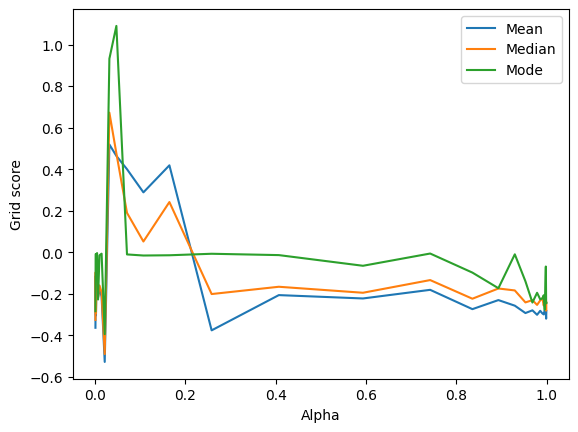

In [18]:
# NaNs to zeors

grid_scores = np.load('./gridsearch/rnngc_grid_scores_l2.npy')
alphas = np.load('./gridsearch/rnnc_grid_scores_alphas_l2.npy')

grid_scores[np.isnan(grid_scores)] = 0
grid_scores_binned = []
gs_modes = np.zeros(len(grid_scores))

gs_means = np.mean(grid_scores, axis = 1)
gs_meadians = np.median(grid_scores, axis = 1)
# mode on 30 bins
for i in range(len(grid_scores)):
    grid_scores_binned.append(np.histogram(grid_scores[i], bins = 100))
    gs_modes[i] = grid_scores_binned[i][1][np.argmax(grid_scores_binned[i][0])]
plt.plot(alphas, gs_means, label = 'Mean')
plt.plot(alphas, gs_meadians, label = 'Median')
plt.plot(alphas, gs_modes, label = 'Mode')
plt.xlabel('Alpha')
plt.ylabel('Grid score')
plt.legend()
# plt.savefig('./gridsearch/ffgc_grid_scores.png')
plt.show()

In [16]:
mode_max = alphas[np.argmax(gs_modes)]
mean_max = alphas[np.argmax(gs_means)]
median_max = alphas[np.argmax(gs_meadians)]
print(f'Mode max: {mode_max}')
print(f'Mean max: {mean_max}')
print(f'Median max: {median_max}')

Mode max: 0.8353177231330299
Mean max: 0.892842094057908
Median max: 0.892842094057908
